In [7]:
import torch
from shared.img_to_graph import img_to_graph

savedir = "_05_ct_images/data"
images = torch.load(savedir + "/augmented_images.pt")
labels = torch.load(savedir + "/augmented_labels.pt")
print(f"Loaded augmented images shape: {images.shape}")
print(f"Loaded augmented labels shape: {labels.shape}")

Loaded augmented images shape: torch.Size([10000, 224, 224])
Loaded augmented labels shape: torch.Size([10000])


In [ ]:

sample = images[0]

a = img_to_graph(sample,)

torch.Size([224, 224, 3])


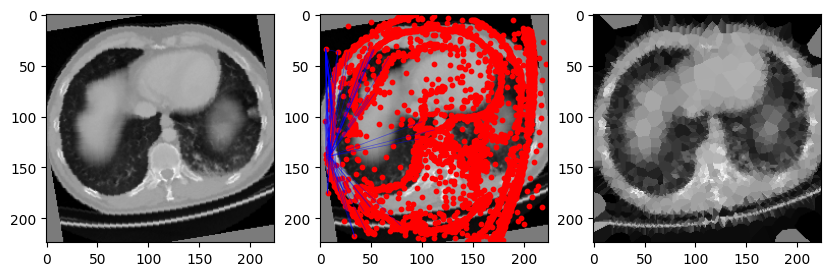

In [ ]:
img = sample.unsqueeze(-1).repeat(1,1,3)
print(img.shape)
img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]

fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(img.numpy())
ax[1].imshow(img.numpy())


X = a[0]
edge_index = a[1]
edge_weight = a[2]
centroids = a[3]

centroids_x = centroids[:, 1]
centroids_y = centroids[:, 0]

ax[1].scatter(centroids_x, centroids_y, c='red', s=10, label='Centroids')
for i in range(100):
    n1, n2 = edge_index[i, :]
    x1, y1 = centroids[n1]
    x2, y2 = centroids[n2]
    ax[1].plot([x1, x2], [y1, y2], c='blue', alpha=0.5, linewidth=0.5)

voronoi = torch.zeros_like(img, dtype=torch.float32)

for i in range(voronoi.shape[0]):
    for j in range(voronoi.shape[1]):
        distances = torch.sqrt((centroids_x - i) ** 2 + (centroids_y - j) ** 2)
        closest_centroid = torch.argmin(distances)
        voronoi[i, j] = X[closest_centroid]

voronoi = (voronoi - voronoi.min()) / (voronoi.max() - voronoi.min())  # Normalize to [0, 1]

ax[2].imshow(voronoi.numpy(), cmap='gray')

3487 14327 14327 3487


(array([ 10.,  37., 103., 231., 494., 802., 585., 384., 133., 130., 105.,
         84.,  58.,  45.,  37.,  38.,  27.,  25.,  11.,   6.,  22.,   9.,
         14.,   7.,   8.,   8.,   4.,   7.,   4.,   0.,   8.,   3.,   6.,
          2.,   2.,   3.,   4.,   3.,   2.,   4.,   1.,   2.,   0.,   0.,
          4.,   0.,   0.,   3.,   1.,   1.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.]),
 array([ 1.        ,  1.96666667,  2.93333333,  3.9       ,  4.86666667,
         5.83333333,  6.8       ,  7.76666667,  8.73333333,  9.7       ,
        10.66666667, 11.63333333, 12.6       , 13.56666667, 14.53333333,
        15.5       , 16.46666667, 17.43333333, 18.4       , 19.36666667,
        20.33333333, 21.3       , 22.26666667, 23.23333333, 24.2       ,
        25.16666667, 

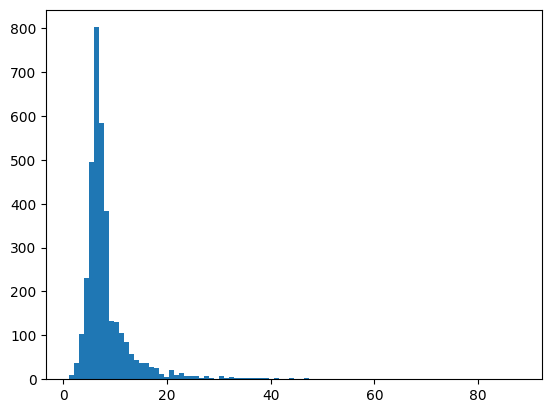

In [51]:
import matplotlib.pyplot as plt
print(len(X), len(edge_index), len(edge_weight), len(centroids))

avg_deg = len(edge_index) / len(X)

degree_distribution = torch.zeros(len(X), dtype=torch.int32)
for i in range(len(edge_index)):
    degree_distribution[edge_index[i, 0]] += 1
    degree_distribution[edge_index[i, 1]] += 1
    
plt.hist(degree_distribution.numpy(), bins=90)


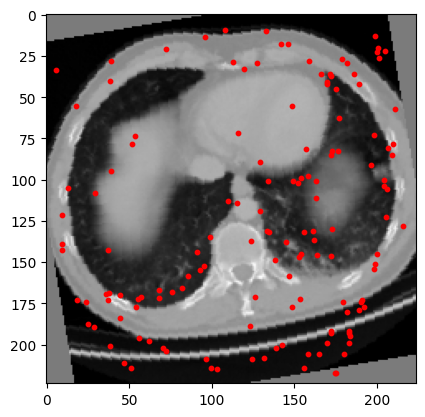

In [52]:
nodes_with_high_degree = torch.where(degree_distribution > 20)[0]

plt.imshow(img.numpy())

plt.scatter(centroids_x[nodes_with_high_degree], centroids_y[nodes_with_high_degree], c='red', s=10, label='High Degree Nodes')

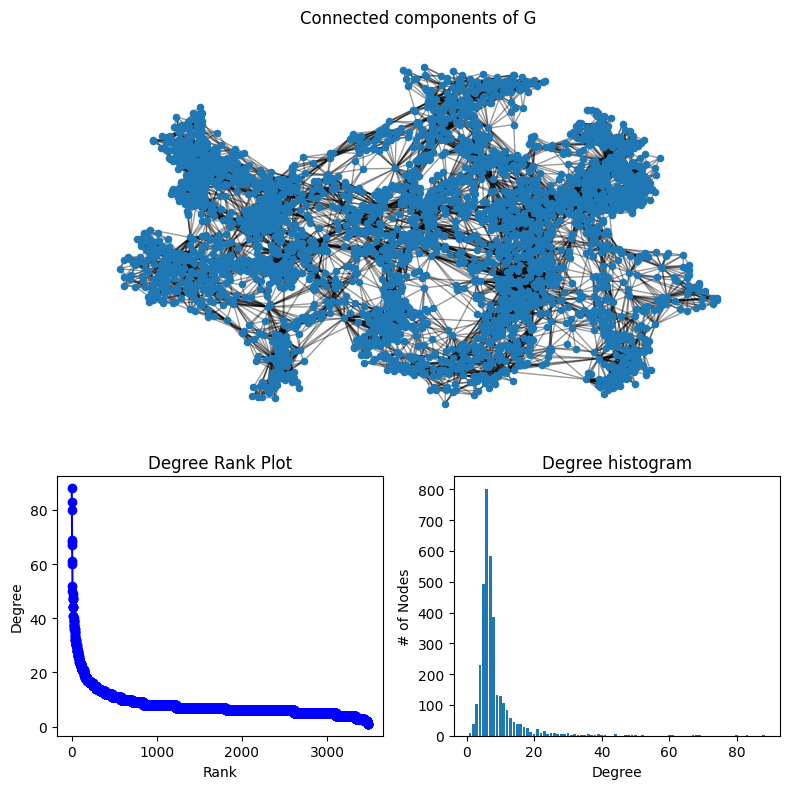

In [43]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

G = nx.Graph()
for i in range(len(edge_index)):
    G.add_edge(edge_index[i, 0].item(), edge_index[i, 1].item())

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()